In [1]:
import os
import time
import shutil
import tarfile
import pathlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
import xgboost as xgb 
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, r2_score
from sklearn.linear_model import Lasso, LassoCV, MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import optimizers
from keras.initializers import lecun_normal
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


In [2]:
tf.__version__

'2.0.0'

In [3]:
PATH_INPUT_TABLE = '[i] data/'

In [4]:
if not(os.path.isdir(PATH_INPUT_TABLE)):
    os.makedirs(PATH_INPUT_TABLE)

In [5]:
# CSV TO DATA
def csvToData(csv_file):
    df = pd.read_csv(csv_file, header = 0)
    column = list(df.columns.values)
    data = df.values
    return column, data

sample_column, sample_csv_data = csvToData(PATH_INPUT_TABLE+"sample_submission.csv")
test_column, test_csv_data = csvToData(PATH_INPUT_TABLE+"test.csv")
train_column, train_csv_data = csvToData(PATH_INPUT_TABLE+"train.csv")
print('sample_submission-----------')
print(sample_column)
print(sample_csv_data.shape)
print('test-----------')
print(test_column)
print(test_csv_data.shape)
print('train-----------')
print(train_column)
print(train_csv_data.shape)


sample_submission-----------
['id', 'hhb', 'hbo2', 'ca', 'na']
(10000, 5)
test-----------
['id', 'rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_src', '730_src', '740_src', '750_src', '760_src', '770_src', '780_src', '790_src', '800_src', '810_src', '820_src', '830_src', '840_src', '850_src', '860_src', '870_src', '880_src', '890_src', '900_src', '910_src', '920_src', '930_src', '940_src', '950_src', '960_src', '970_src', '980_src', '990_src', '650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst', '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst', '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst', '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst', '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst', '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']
(10000, 72)
train-----------
['id', 'rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_s

In [6]:
# Data to DataFrame
sample_data = pd.DataFrame(sample_csv_data, columns=sample_column)
test_data = pd.DataFrame(test_csv_data, columns=test_column)
train_data = pd.DataFrame(train_csv_data, columns=train_column)
print(sample_data.shape, test_data.shape, train_data.shape)

(10000, 5) (10000, 72) (10000, 76)


In [7]:
src_list=['650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_src', '730_src', 
          '740_src', '750_src', '760_src', '770_src', '780_src', '790_src', '800_src', '810_src', '820_src', 
          '830_src', '840_src', '850_src', '860_src', '870_src', '880_src', '890_src', '900_src', '910_src', 
          '920_src', '930_src', '940_src', '950_src', '960_src', '970_src', '980_src', '990_src']
dst_list=['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst', '710_dst', '720_dst', '730_dst', 
          '740_dst', '750_dst', '760_dst', '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst', 
          '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst', '890_dst', '900_dst', '910_dst', 
          '920_dst', '930_dst', '940_dst', '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']

In [8]:
# 보간법 tqdm , 
from tqdm import tqdm
alpha=train_data[dst_list]
beta=test_data[dst_list]

for i in tqdm(train_data.index):
    alpha.loc[i] = alpha.loc[i].interpolate()
    
for i in tqdm(test_data.index):
    beta.loc[i] = beta.loc[i].interpolate()
    
#위에 보간법을 사용하게되면, 앞단에 비는 경우가 발생. 빌 경우 뒷단에 있는 데이터를 끌어다가 씀.
alpha.loc[alpha['700_dst'].isnull(),'700_dst']=alpha.loc[alpha['700_dst'].isnull(),'710_dst']
alpha.loc[alpha['690_dst'].isnull(),'690_dst']=alpha.loc[alpha['690_dst'].isnull(),'700_dst']
alpha.loc[alpha['680_dst'].isnull(),'680_dst']=alpha.loc[alpha['680_dst'].isnull(),'690_dst']
alpha.loc[alpha['670_dst'].isnull(),'670_dst']=alpha.loc[alpha['670_dst'].isnull(),'680_dst']
alpha.loc[alpha['660_dst'].isnull(),'660_dst']=alpha.loc[alpha['660_dst'].isnull(),'670_dst']
alpha.loc[alpha['650_dst'].isnull(),'650_dst']=alpha.loc[alpha['650_dst'].isnull(),'660_dst']

beta.loc[beta['700_dst'].isnull(),'700_dst']=beta.loc[beta['700_dst'].isnull(),'710_dst']
beta.loc[beta['690_dst'].isnull(),'690_dst']=beta.loc[beta['690_dst'].isnull(),'700_dst']
beta.loc[beta['680_dst'].isnull(),'680_dst']=beta.loc[beta['680_dst'].isnull(),'690_dst']
beta.loc[beta['670_dst'].isnull(),'670_dst']=beta.loc[beta['670_dst'].isnull(),'680_dst']
beta.loc[beta['660_dst'].isnull(),'660_dst']=beta.loc[beta['660_dst'].isnull(),'670_dst']
beta.loc[beta['650_dst'].isnull(),'650_dst']=beta.loc[beta['650_dst'].isnull(),'660_dst']

train_data[dst_list] = np.array(alpha)
test_data[dst_list] = np.array(beta)

100%|██████████| 10000/10000 [00:08<00:00, 1193.37it/s]


In [9]:
# rho 값의 제곱을 dst에 곱해줌.
for col in dst_list:
    train_data[col] = train_data[col] * (train_data['rho'] ** 2)
    test_data[col] = test_data[col] * (test_data['rho']**2)

In [10]:
# rho 값을 범주형 변수로 가정하고 원-핫-인코딩 적용 (JYH)
train_data[['rho_10', 'rho_15', 'rho_20', 'rho_25']] = pd.get_dummies(train_data['rho'])
test_data[['rho_10', 'rho_15', 'rho_20', 'rho_25']] = pd.get_dummies(test_data['rho'])

In [11]:
#원래 빛과 측정빛의 차이값을 변수로 추가
gap_feature_names=[]
for i in range(650, 1000, 10):
    gap_feature_names.append(str(i) + '_gap')

alpha=pd.DataFrame(np.array(train_data[src_list]) - np.array(train_data[dst_list]), columns=gap_feature_names, index=train_data.index)
beta=pd.DataFrame(np.array(test_data[src_list]) - np.array(test_data[dst_list]), columns=gap_feature_names, index=test_data.index)

train_data=pd.concat((train_data, alpha), axis=1)
test_data=pd.concat((test_data, beta), axis=1)

In [12]:
#원래 빛과 측정빛의 차이 비율을 변수 추가
epsilon=1e-10

for dst_col, src_col in zip(dst_list, src_list):
    dst_val=train_data[dst_col]
    src_val=train_data[src_col] + epsilon
    
    delta_ratio = dst_val / src_val
    train_data[dst_col + '_' + src_col + '_ratio'] = delta_ratio
    
    dst_val=test_data[dst_col]
    src_val=test_data[src_col] + epsilon
    
    delta_ratio = dst_val / src_val
    test_data[dst_col + '_' + src_col + '_ratio'] = delta_ratio

In [13]:
##측정 빛에 이산 푸리에 변환
alpha_real=train_data[dst_list]
alpha_imag=train_data[dst_list]

beta_real=test_data[dst_list]
beta_imag=test_data[dst_list]

for i in tqdm(alpha_real.index):
    alpha_real.loc[i]=alpha_real.loc[i] - alpha_real.loc[i].mean()
    alpha_imag.loc[i]=alpha_imag.loc[i] - alpha_real.loc[i].mean()
    
    alpha_real.loc[i] = np.fft.fft(alpha_real.loc[i], norm='ortho').real
    alpha_imag.loc[i] = np.fft.fft(alpha_imag.loc[i], norm='ortho').imag

    
for i in tqdm(beta_real.index):
    beta_real.loc[i]=beta_real.loc[i] - beta_real.loc[i].mean()
    beta_imag.loc[i]=beta_imag.loc[i] - beta_imag.loc[i].mean()
    
    beta_real.loc[i] = np.fft.fft(beta_real.loc[i], norm='ortho').real
    beta_imag.loc[i] = np.fft.fft(beta_imag.loc[i], norm='ortho').imag
    
real_part=[]
imag_part=[]

for col in dst_list:
    real_part.append(col + '_fft_real')
    imag_part.append(col + '_fft_imag')
    
alpha_real.columns=real_part
alpha_imag.columns=imag_part
alpha = pd.concat((alpha_real, alpha_imag), axis=1)

beta_real.columns=real_part
beta_imag.columns=imag_part
beta=pd.concat((beta_real, beta_imag), axis=1)

train_data=pd.concat((train_data, alpha), axis=1)
test_data=pd.concat((test_data, beta), axis=1)

100%|██████████| 10000/10000 [00:27<00:00, 363.05it/s]


In [14]:
print(np.isnan(train_data).values.any(),np.isnan(test_data).values.any())

False False


## Data split

training data ( 8000개 ) = train_dataset

validataion data ( 2000개 ) = test_dataset

In [15]:
num_traindata = 8000
num_validdata = 2000
from sklearn.utils import shuffle
train_data = shuffle(train_data)
train_dataset = train_data[:num_traindata]
valid_dataset = train_data[num_traindata : num_traindata + num_validdata]
train_dataset = train_dataset.drop('id',axis = 1)
valid_dataset = valid_dataset.drop('id',axis = 1)
print(train_dataset.shape, valid_dataset.shape)

(8000, 219) (2000, 219)


In [67]:
train_data

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_dst_fft_imag,910_dst_fft_imag,920_dst_fft_imag,930_dst_fft_imag,940_dst_fft_imag,950_dst_fft_imag,960_dst_fft_imag,970_dst_fft_imag,980_dst_fft_imag,990_dst_fft_imag
4908,4908.0,20.0,0.00393,0.02553,0.02271,0.01443,0.03182,0.03194,0.01523,0.02628,...,-1.139582e-13,-1.136861e-13,-1.384756e-13,-1.571297e-13,-1.799107e-13,-1.035146e-13,-9.438959e-14,-6.998734e-14,-6.915367e-14,-9.940690e-14
2807,2807.0,10.0,0.02273,0.03729,0.08000,0.11787,0.19897,0.28580,0.39697,0.53947,...,-1.917225e-08,-3.305253e-08,4.355270e-08,-4.904217e-08,3.485993e-08,6.468906e-08,-1.885285e-07,2.813384e-07,-1.040865e-06,1.466962e-06
5258,5258.0,25.0,0.31059,0.41715,0.59275,0.76619,0.90889,1.00007,0.96131,0.69899,...,-5.915751e-17,9.231747e-17,3.808453e-17,-6.060838e-17,-2.265452e-16,-1.286364e-16,8.195278e-17,5.180375e-16,7.462006e-16,5.772523e-16
7021,7021.0,20.0,0.00000,0.00970,0.00000,0.00000,0.00000,0.00966,0.00000,0.01833,...,7.380848e-15,-5.940883e-15,4.793753e-16,3.541740e-15,-4.087366e-15,1.544155e-15,2.151677e-15,-7.198432e-15,1.148322e-14,-8.468656e-15
3680,3680.0,20.0,0.39621,0.45970,0.51136,0.61415,0.73093,0.85691,0.94143,0.98581,...,1.349706e-14,-1.652993e-13,-1.485800e-13,-4.759372e-14,-4.397559e-13,7.000081e-14,-4.723807e-13,2.670099e-13,-3.630522e-13,2.726934e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,997.0,15.0,0.02568,0.00112,0.00961,0.02469,0.04499,0.06091,0.05572,0.08842,...,-2.096780e-11,-2.507024e-11,-2.857861e-11,-1.114711e-11,-5.352160e-11,-1.407007e-11,-3.955522e-11,-1.744600e-11,4.618345e-12,-4.902204e-11
8464,8464.0,15.0,0.01540,0.00000,0.00237,0.00000,0.01880,0.00000,0.00990,0.03056,...,1.384018e-11,-1.072993e-11,-1.733089e-11,2.045954e-11,-5.371442e-11,3.199668e-11,-5.186921e-12,-7.044573e-13,4.708501e-11,-1.100751e-10
9341,9341.0,10.0,0.76071,0.90137,0.99377,0.96871,0.83110,0.56784,0.32720,0.16785,...,1.496878e-10,1.589790e-10,-3.612640e-11,-3.463144e-10,-2.370435e-10,-2.697803e-11,2.684266e-10,7.034646e-10,8.410751e-10,3.857448e-10
7006,7006.0,25.0,0.58160,0.73483,0.92156,1.00411,0.82988,0.38206,0.08654,0.00709,...,-7.450515e-16,-2.520760e-15,-3.916058e-15,-3.184411e-15,-1.451819e-15,1.615570e-15,4.630121e-15,6.073952e-15,6.249318e-15,3.429235e-15


## Data split

--training data ( 8000 )

x_train

y_train

--validation data ( 2000 )

x_test

y_test

--training data ( 10000 )

x_train_sample 

y_train_sample

In [16]:
train_dataset.keys()

Index(['rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src',
       '710_src', '720_src', '730_src',
       ...
       '900_dst_fft_imag', '910_dst_fft_imag', '920_dst_fft_imag',
       '930_dst_fft_imag', '940_dst_fft_imag', '950_dst_fft_imag',
       '960_dst_fft_imag', '970_dst_fft_imag', '980_dst_fft_imag',
       '990_dst_fft_imag'],
      dtype='object', length=219)

In [17]:
#x_train, y_train 분류
x_train = train_dataset.loc[:, 'rho':] # train dataset
x_train.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train = train_dataset.loc[:, 'hhb':'na'] # train labels
x_train.shape, y_train.shape

((8000, 215), (8000, 4))

In [18]:
#x_test, y_test 분류
x_test = valid_dataset.loc[:, 'rho':] # test dataset
x_test.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_test = valid_dataset.loc[:, 'hhb':'na'] # test labels
x_test.shape, y_test.shape

((2000, 215), (2000, 4))

In [19]:
#sample Code 용
#x_train_sample = train_data.loc[:, 'rho':] # train dataset
x_train_sample = train_data.loc[:, '650_src':] # train dataset
x_train_sample.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train_sample = train_data.loc[:, 'hhb':'na'] # train labels
x_train_sample.shape, y_train_sample.shape

((10000, 214), (10000, 4))

In [48]:
#sample Code 용
#x_train_sample = train_data.loc[:, 'rho':] # test dataset
x_test_sample = test_data.loc[:, '650_src':] # test dataset
#x_test_sample.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
#y_test_sample = test_data.loc[:, 'hhb':'na'] # train labels
x_test_sample.shape#, y_test_sample.shape

(10000, 214)

hhb (10000, 214) (10000, 150)
hbo2 (10000, 214) (10000, 150)
ca (10000, 214) (10000, 150)
na (10000, 214) (10000, 150)


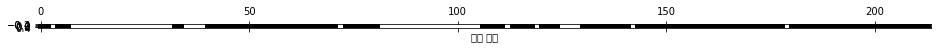

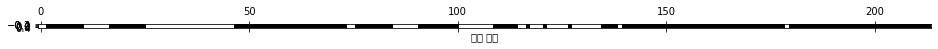

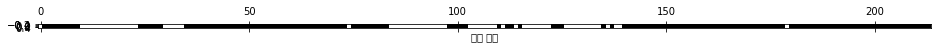

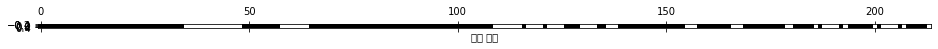

In [50]:
# 특성 선택 (일변량 통계) (JYH)
from sklearn.feature_selection import SelectPercentile

select = SelectPercentile(percentile=70)

x_train_selected = {}
x_test_selected = {}
for col in y_train_sample.columns:
    select.fit(x_train_sample, y_train_sample[col])
    np_selected = select.transform(x_train_sample)
    mask = select.get_support()
    
    x_train_selected[col] = pd.DataFrame(np_selected, columns=x_train_sample.columns[mask])
    x_test_selected[col] = pd.DataFrame(x_test_sample[x_train_sample.columns[mask]], columns=x_train_sample.columns[mask])
    
    print(col, x_train_sample.shape, x_train_selected[col].shape)
    plt.matshow(mask.reshape(1,-1), cmap='gray_r')
    plt.xlabel('특성 번호')

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [33]:
# https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

def FitModel(x_data, y_data):
    xgbr = xgb.XGBRegressor(verbosity=0) 
    print(xgbr)
    XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, colsample_bytree=1, gamma=0,
           importance_type='gain', learning_rate=0.1, max_delta_step=0,
           max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
           n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
           silent=None, subsample=1, verbosity=1)

    #Next, we'll fit the model with train data.

    xgbr.fit(x_data, y_data)
    
    score = xgbr.score(x_data, y_data)
    print("training score", score)
    
    #k_fold = kFold(n_split=5, shuffle=True)
    #scores = cross_val_score(xgbr, x_data, y_data, cv=k_fold)
    #print("K-fold CV average score: %.2f" % scores.mean())
    scores = cross_val_score(xgbr, x_data, y_data,cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())

    return xgbr
    
models = {}
for label in y_train.columns:
    print(label)
    models[label] = FitModel(x_train_selected[label], y_train_sample[label])

hhb
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=0)
training score 0.9838870243474876
Mean cross-validation score: 0.82
hbo2
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None,

In [65]:
x_train

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst_fft_imag,910_dst_fft_imag,920_dst_fft_imag,930_dst_fft_imag,940_dst_fft_imag,950_dst_fft_imag,960_dst_fft_imag,970_dst_fft_imag,980_dst_fft_imag,990_dst_fft_imag
4908,20.0,0.00393,0.02553,0.02271,0.01443,0.03182,0.03194,0.01523,0.02628,0.04545,...,-1.139582e-13,-1.136861e-13,-1.384756e-13,-1.571297e-13,-1.799107e-13,-1.035146e-13,-9.438959e-14,-6.998734e-14,-6.915367e-14,-9.940690e-14
2807,10.0,0.02273,0.03729,0.08000,0.11787,0.19897,0.28580,0.39697,0.53947,0.65160,...,-1.917225e-08,-3.305253e-08,4.355270e-08,-4.904217e-08,3.485993e-08,6.468906e-08,-1.885285e-07,2.813384e-07,-1.040865e-06,1.466962e-06
5258,25.0,0.31059,0.41715,0.59275,0.76619,0.90889,1.00007,0.96131,0.69899,0.37077,...,-5.915751e-17,9.231747e-17,3.808453e-17,-6.060838e-17,-2.265452e-16,-1.286364e-16,8.195278e-17,5.180375e-16,7.462006e-16,5.772523e-16
7021,20.0,0.00000,0.00970,0.00000,0.00000,0.00000,0.00966,0.00000,0.01833,0.00000,...,7.380848e-15,-5.940883e-15,4.793753e-16,3.541740e-15,-4.087366e-15,1.544155e-15,2.151677e-15,-7.198432e-15,1.148322e-14,-8.468656e-15
3680,20.0,0.39621,0.45970,0.51136,0.61415,0.73093,0.85691,0.94143,0.98581,0.98548,...,1.349706e-14,-1.652993e-13,-1.485800e-13,-4.759372e-14,-4.397559e-13,7.000081e-14,-4.723807e-13,2.670099e-13,-3.630522e-13,2.726934e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,25.0,0.09451,0.12436,0.12859,0.11191,0.16222,0.17429,0.16601,0.20395,0.21942,...,-2.023351e-15,-1.960431e-15,-3.052339e-15,-9.923721e-16,-3.665836e-15,3.917456e-16,-3.846932e-15,2.707163e-16,-1.732405e-15,-1.438306e-16
7189,25.0,0.05199,0.08407,0.14495,0.27760,0.42590,0.62326,0.81077,0.93345,0.99884,...,2.271238e-15,-1.232166e-15,-1.316221e-15,-6.236837e-16,1.939093e-15,2.853883e-15,-4.667338e-15,2.047383e-15,-5.823509e-16,6.260451e-15
1297,15.0,0.14829,0.19828,0.26920,0.34130,0.44470,0.59444,0.80457,0.96600,0.99630,...,-2.715491e-12,-7.786775e-13,-4.244453e-12,-6.295657e-12,-8.193169e-12,9.836053e-12,-8.841215e-12,-5.056509e-12,3.327102e-12,1.920327e-11
44,25.0,0.00000,0.01232,0.01206,0.00512,0.00000,0.01485,0.00000,0.00000,0.00328,...,-8.449794e-18,-2.895798e-17,-2.126008e-17,-8.551435e-18,-4.229615e-17,8.674962e-18,-3.312183e-17,-8.246825e-18,-3.421862e-18,-1.301328e-17


In [63]:
y_train

,hhb,hbo2,ca,na
4908,8.13,5.47,11.12,4.25
2807,1.84,4.66,2.69,0.40
5258,8.56,4.32,11.28,3.49
7021,13.22,4.58,12.42,7.45
3680,7.91,4.87,7.30,2.22
...,...,...,...,...
4026,7.70,4.71,11.83,1.96
7189,6.70,4.80,5.28,0.98
1297,12.28,2.70,13.45,1.66
44,11.76,5.41,12.19,0.33


In [97]:
y_tests = list()
y_tests.append(list(range(10000, 20000)))
for label in y_train.columns:
    print(label)
    result = models[label].predict(x_test_selected[label])
    y_tests.append(result)
y_pred = pd.DataFrame(y_tests, index=['id']+list(y_train_sample.columns)).T
y_pred = y_pred.astype({'id': int})
y_pred

hhb
hbo2
ca
na


,id,hhb,hbo2,ca,na
0,10000,8.174425,4.642029,7.249260,1.981202
1,10001,7.634184,2.442703,8.832917,3.015932
2,10002,9.578682,5.030324,11.238374,3.986597
3,10003,7.618618,4.658961,9.291983,4.149244
4,10004,6.985091,3.244745,9.380476,2.970147
...,...,...,...,...,...
9995,19995,5.255647,3.678809,12.882713,3.987148
9996,19996,10.645096,2.375051,6.086343,1.619865
9997,19997,8.034638,4.456069,7.897162,4.913260
9998,19998,11.846595,4.511755,10.338509,2.658466


In [98]:
#Save Excel 
#sample_data.to_csv('Dacon_Yeonghwan_20200621_1.csv', index=False)
y_pred.to_csv('Dacon_Yeonghwan_20200621_1.csv', index=False)